In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import time

In [2]:
import os
import gzip
import numpy as np


def load_mnist(path, kind='train'):
    """Load MNIST data from path"""
    labels_path = os.path.join(path,
                              '%s-labels-idx1-ubyte.gz'
                              % kind)
    images_path = os.path.join(path,
                              '%s-images-idx3-ubyte.gz'
                              % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                             offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                             offset=16).reshape(len(labels), 784)

    return images, labels

# Load dữ liệu
X_train, y_train = load_mnist('/content/', kind='train')
X_test, y_test = load_mnist('/content/', kind='t10k')

# Flatten 28x28 images into 1D vectors of 784 features
X_train = X_train.reshape(X_train.shape[0], -1) # Flatten and normalize
X_test = X_test.reshape(X_test.shape[0], -1)



<Axes: xlabel='label'>

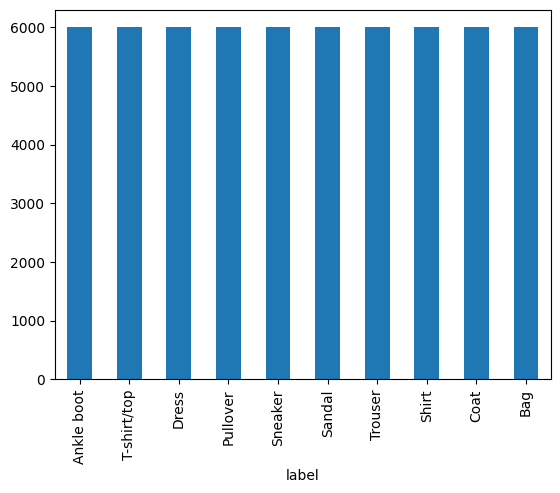

In [3]:
# Class distribution visualization

import pandas as pd
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
df = pd.DataFrame(X_train)
df['label'] = y_train
df['label'] = df['label'].apply(lambda x: class_names[x])
df['label'].value_counts().plot(kind='bar')

In [4]:
df.isna().sum()

,0
0,0
1,0
2,0
3,0
4,0
...,...
780,0
781,0
782,0
783,0


In [5]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.000800,0.005783,0.030083,0.103800,0.249683,0.414717,0.821667,2.224733,5.698667,14.434650,...,34.564367,23.208633,16.576250,17.831967,22.918850,17.916900,8.485717,2.706333,0.819000,0.070883
std,0.092554,0.249033,0.767868,2.512017,4.331376,5.827394,8.309935,14.201820,23.835980,38.204702,...,57.557779,48.881430,42.044318,43.911297,51.928401,45.173634,29.448614,17.258682,9.133252,2.075829
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,57.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,16.000000,36.000000,119.000000,164.000000,224.000000,230.000000,221.000000,221.000000,254.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.000000


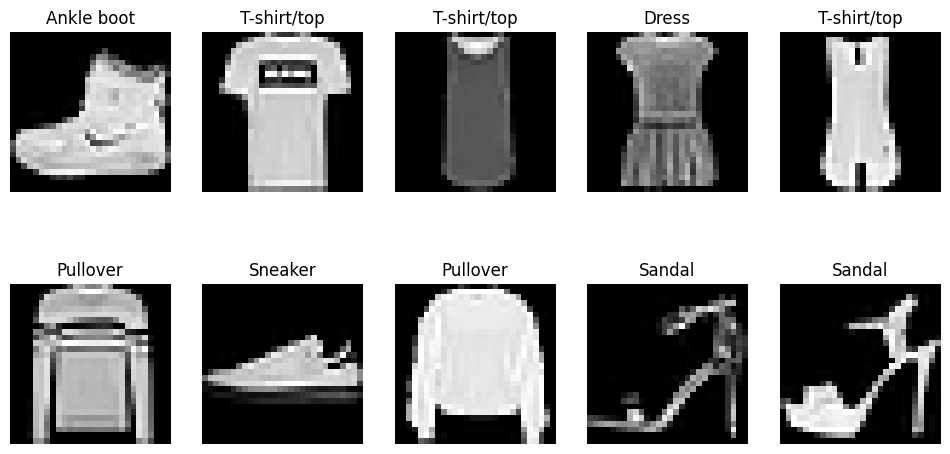

In [6]:
def show_samples(x, y, class_names):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(x[i].reshape(28, 28), cmap="gray")
        plt.title(class_names[y[i]])
        plt.axis("off")
    plt.show()

show_samples(X_train, y_train, class_names)

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score

# Custom Logistic Regression Class
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_epochs=1000, batch_size=128):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.losses = []

    def softmax(self, z):
        """Compute the softmax function."""
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def one_hot_encode(self, y):
        """One-hot encode the target labels."""
        n_classes = len(np.unique(y))
        return np.eye(n_classes)[y]

    def initialize_parameters(self, num_features, num_classes):
        """Initialize weights and bias."""
        self.weights = np.zeros((num_features, num_classes))
        self.bias = np.zeros(num_classes)

    def get_batches(self, X, y, batch_size):
        """Create mini-batches for mini-batch gradient descent."""
        n_samples = len(X)
        indices = np.arange(n_samples)
        np.random.shuffle(indices)

        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            yield X[batch_indices], y[batch_indices]

    def fit(self, X, y):
        """Train the model."""
        X = X / 255.0  # Normalize data

        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        self.initialize_parameters(n_features, n_classes)
        y_encoded = self.one_hot_encode(y)

        for epoch in range(self.num_epochs):
            epoch_loss = 0
            batch_count = 0

            for batch_X, batch_y in self.get_batches(X, y_encoded, self.batch_size):
                z = np.dot(batch_X, self.weights) + self.bias
                y_pred = self.softmax(z)

                batch_loss = -np.mean(np.sum(batch_y * np.log(y_pred + 1e-15), axis=1))
                epoch_loss += batch_loss
                batch_count += 1

                d_y_pred = y_pred - batch_y
                d_weights = np.dot(batch_X.T, d_y_pred) / len(batch_X)
                d_bias = np.mean(d_y_pred, axis=0)

                self.weights -= self.learning_rate * d_weights
                self.bias -= self.learning_rate * d_bias

            epoch_loss /= batch_count
            self.losses.append(epoch_loss)

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {epoch_loss:.4f}')

    def predict(self, X):
        """Predict class labels for samples in X."""
        X = X / 255.0  # Normalize data
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(z)
        return np.argmax(y_pred, axis=1)

    def evaluate(self, X, y):
        """Evaluate the model."""
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

# Function to train and evaluate both models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    # Custom Logistic Regression
    custom_model = LogisticRegression(
        learning_rate=0.1,
        num_epochs=200,
        batch_size=128
    )

    print("Training custom Logistic Regression...")
    custom_model.fit(X_train, y_train)
    custom_train_accuracy = custom_model.evaluate(X_train, y_train)
    custom_test_accuracy = custom_model.evaluate(X_test, y_test)

    print(f"Custom Model - Train Accuracy: {custom_train_accuracy:.4f}")
    print(f"Custom Model - Test Accuracy: {custom_test_accuracy:.4f}")



# Load and prepare the dataset
    # Flatten to 784

# Run the model evaluation
#train_and_evaluate_models(X_train, y_train, X_test, y_test)

WHEN NORMALIZE DATA INPUT BY DIVIDE FOR 255, THE MODEL LOSS PERFORMANCE IS HIGH???  BUT THE ACCURACY IS SAME SAME

In [8]:
start_time_LG = time.time()
LG = LogisticRegression(num_epochs = 200, learning_rate = 0.1, batch_size = 128)
LG.fit(X_train, y_train)
time_LG = time.time() - start_time_LG
print(f"Training time: {time_LG} seconds")

Epoch [10/200], Loss: 0.4261
Epoch [20/200], Loss: 0.4069
Epoch [30/200], Loss: 0.3963
Epoch [40/200], Loss: 0.3897
Epoch [50/200], Loss: 0.3848
Epoch [60/200], Loss: 0.3806
Epoch [70/200], Loss: 0.3785
Epoch [80/200], Loss: 0.3767
Epoch [90/200], Loss: 0.3750
Epoch [100/200], Loss: 0.3718
Epoch [110/200], Loss: 0.3707
Epoch [120/200], Loss: 0.3696
Epoch [130/200], Loss: 0.3688
Epoch [140/200], Loss: 0.3672
Epoch [150/200], Loss: 0.3662
Epoch [160/200], Loss: 0.3653
Epoch [170/200], Loss: 0.3641
Epoch [180/200], Loss: 0.3643
Epoch [190/200], Loss: 0.3643
Epoch [200/200], Loss: 0.3633
Training time: 101.12776017189026 seconds


In [9]:
y_pred = LG.predict(X_test)

Logistic Regression - Accuracy: 0.84
Precision: 0.8424765008902019
Recall: 0.84
F1 Score: 0.8402516231533056

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.82      0.78      0.80      1000
     Trouser       0.97      0.95      0.96      1000
    Pullover       0.69      0.77      0.73      1000
       Dress       0.82      0.87      0.85      1000
        Coat       0.79      0.66      0.72      1000
      Sandal       0.94      0.93      0.93      1000
       Shirt       0.59      0.61      0.60      1000
     Sneaker       0.91      0.94      0.92      1000
         Bag       0.94      0.94      0.94      1000
  Ankle boot       0.95      0.94      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



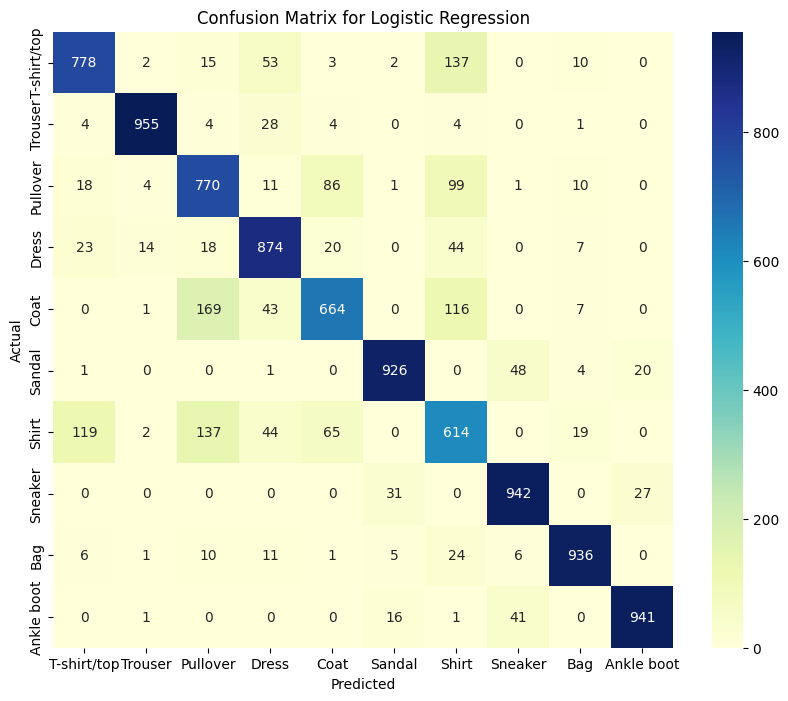

In [10]:
# Evaluation metrics for Logistic Regression
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Logistic Regression - Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


ITEMS ARE MORE EASILY CONFUSED:
-T-shirt/top and Shirt: The model seems to have difficulty distinguishing between shirts and T-shirt/top trousers, as there is a relatively high number of misclassifications between these two classes.

- Pullover and Shirt, Coat

- Sandal and Sneaker: While not as prominent as the previous examples, the model also has some trouble distinguishing between sandals and sneakers.


In [11]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [12]:
# Initialize and train the SVM with a linear kernel
#one versus one

# Normalize the data


start_time_svm_linear = time.time()
linear_svm = SVC(kernel='linear', C=1.0)
linear_svm.fit(X_train_normalized, y_train)
linear_test_accuracy = accuracy_score(y_test, linear_svm.predict(X_test_normalized))
svm_linear_train_time = time.time() - start_time_svm_linear
print(f"Linear Kernel SVM:")
print(f"Test Accuracy: {linear_test_accuracy:.4f}")
print(f"Training Time: {svm_linear_train_time:.4f} seconds")



Linear Kernel SVM:
Test Accuracy: 0.8370
Training Time: 1798.3386 seconds


In [13]:
# Train and evaluate the RBF kernel SVM
start_time_svm_rbf = time.time()
rbf_svm = SVC(kernel='rbf', C=1.0, gamma='scale')
rbf_svm.fit(X_train_normalized, y_train)
rbf_test_accuracy = accuracy_score(y_test, rbf_svm.predict(X_test_normalized))
rbf_train_time = time.time() - start_time_svm_rbf
print("\nRBF Kernel SVM:")
print(f"Test Accuracy: {rbf_test_accuracy:.4f}")
print(f"Training Time: {rbf_train_time:.4f} seconds")


RBF Kernel SVM:
Test Accuracy: 0.8836
Training Time: 639.4071 seconds


In [ ]:
#The main idea behind LDA is to find a projection that maximizes the separation between different classes while minimizing the within-class variance
#What the differences between LDA and PCA?
#PCA is an unsupervised ml method

#LDA is a supervised ml method

#PCA will find the projections that maximize the variance of the data regardless of their grouping

#LDA will try and maximize the distance between those groups

#LDA steps:
# Compute the within class and between class scatter matrices
# Compute the eigenvectors and corresponding eigenvalues for scatter matrices
# Sort the eigenvalues and select top K
# Create a new matrix contaning eigenvectors that map to the k eigenvalues
# Transformation: Obtain the new features (LDA components) by taking the dot product of the data and the matrix from step 4

In [15]:
num_components = min(X_train.shape[1], len(np.unique(y_train)) - 1)
lda = LinearDiscriminantAnalysis(n_components=num_components)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

In [ ]:

print(f"Original feature space dimension: {X_train.shape[1]}")
print(f"Reduced feature space dimension: {X_train_lda.shape[1]}")

# We can now use the reduced-dimensional data for further analysis or modeling


In [17]:
#In Linear Discriminant Analysis (LDA), the number of components you can choose is constrained by the number of classes in your dataset.
# Specifically, you can reduce the dimensionality to at most min(n_classes - 1, n_features).
# In this case: min (10 - 1, 784) = 9, that's why we have 9 dimesion above

In [18]:
# Retrain
start_time_lr = time.time()
lr_lda = LogisticRegression(num_epochs = 200, learning_rate = 0.1, batch_size = 128)

lda_9 =LinearDiscriminantAnalysis(n_components=9)
X_train_lda_9 = lda_9.fit_transform(X_train_normalized, y_train)
X_test_lda_9 = lda_9.transform(X_test_normalized)

model_9_lr = LogisticRegression(num_epochs = 200, learning_rate = 0.1, batch_size = 128)
model_9_lr.fit(X_train_lda_9, y_train)

y_pred_9 = model_9_lr.predict(X_test_lda_9)

end_time_lr = time.time()
accuracy_lr_9 = accuracy_score(y_test, y_pred_9)
time_lr_lda_9 = end_time_lr - start_time_lr

print(f"Logistic Regression (LDA) | \ Accuracy: {accuracy_lr_9} | Time: {time_lr_lda_9} seconds")


# Train SVM on reduced-dimensional data
start_time_svm = time.time()
svm_lda = SVC()
svm_lda.fit(X_train_lda, y_train)
train_accuracy_svm_lda = svm_lda.score(X_train_lda, y_train)
test_accuracy_svm_lda = svm_lda.score(X_test_lda, y_test)
end_time_svm = time.time()
time_svm_lda_9 = end_time_svm - start_time_svm
# Print results for reduced-dimensional data
print(f"SVM (LDA) | Train Accuracy: {train_accuracy_svm_lda:.4f} | Test Accuracy: {test_accuracy_svm_lda:.4f} | Time: {time_svm_lda_9} seconds")

Epoch [10/200], Loss: 2.2825
Epoch [20/200], Loss: 2.2612
Epoch [30/200], Loss: 2.2403
Epoch [40/200], Loss: 2.2196
Epoch [50/200], Loss: 2.1992
Epoch [60/200], Loss: 2.1791
Epoch [70/200], Loss: 2.1594
Epoch [80/200], Loss: 2.1398
Epoch [90/200], Loss: 2.1206
Epoch [100/200], Loss: 2.1017
Epoch [110/200], Loss: 2.0830
Epoch [120/200], Loss: 2.0645
Epoch [130/200], Loss: 2.0464
Epoch [140/200], Loss: 2.0286
Epoch [150/200], Loss: 2.0110
Epoch [160/200], Loss: 1.9937
Epoch [170/200], Loss: 1.9767
Epoch [180/200], Loss: 1.9600
Epoch [190/200], Loss: 1.9434
Epoch [200/200], Loss: 1.9272
Logistic Regression (LDA) | \ Accuracy: 0.7796 | Time: 33.65212321281433 seconds
SVM (LDA) | Train Accuracy: 0.8519 | Test Accuracy: 0.8341 | Time: 130.2646050453186 seconds


In [19]:
#SVM rbf kernel with X_train_lda
start_time_svm_rbf = time.time()
rbf_svm = SVC(kernel='rbf', gamma='scale')
rbf_svm.fit(X_train_lda, y_train)
y_pred_rbf_svm = rbf_svm.predict(X_test_lda)
end_time_svm_rbf_9 = time.time()
accuracy_rbf_svm_9 = accuracy_score(y_test, y_pred_rbf_svm)
time_rbf_svm_9 = end_time_svm_rbf_9 - start_time_svm_rbf

print(f"Accuracy LDA : {accuracy_rbf_svm_9}")
print(f"Time LDA: {time_rbf_svm_9} seconds")

Accuracy LDA : 0.8341
Time LDA: 44.04997372627258 seconds


In [ ]:
#I use LogisticRegresison from sklearn to make fit method perform in my intention: Not show lost in each epoch, only show Accuracy

Components: 9 |  Accuracy: 0.8241
Components: 8 |  Accuracy: 0.8140
Components: 7 |  Accuracy: 0.7854
Components: 6 |  Accuracy: 0.7735
Components: 5 |  Accuracy: 0.7399
Components: 4 |  Accuracy: 0.6983
Components: 3 |  Accuracy: 0.6657
Components: 2 |  Accuracy: 0.5938
Components: 1 |  Accuracy: 0.4758


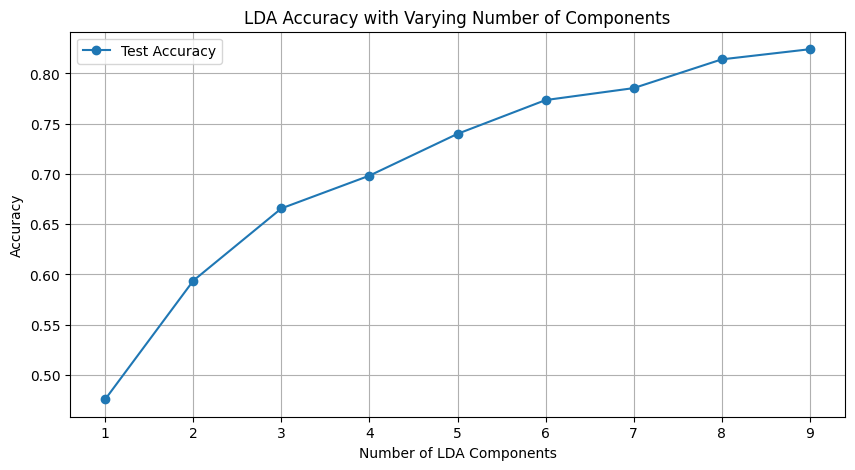

In [26]:
accuracy_results = []
from sklearn.linear_model import LogisticRegression

# Loop through number of components from 9 to 1
for num_components in range(9, 0, -1):
    lda = LinearDiscriminantAnalysis(n_components=num_components)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)

    # Train a logistic regression classifier
    lr = LogisticRegression(max_iter = 1000)
    lr.fit(X_train_lda, y_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(lr.predict(X_test_lda), y_test)

    # Store the results
    accuracy_results.append((num_components, test_accuracy))

    print(f"Components: {num_components} |  Accuracy: {test_accuracy:.4f}")

# Optional: Plotting the accuracy results
components, test_acc = zip(*accuracy_results)

plt.figure(figsize=(10, 5))
plt.plot(components, test_acc, marker='o', label='Test Accuracy')
plt.xticks(components)
plt.xlabel('Number of LDA Components')
plt.ylabel('Accuracy')
plt.title('LDA Accuracy with Varying Number of Components')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Reflect on the trade-offs between dimensionality reduction and model performance.

#We can see with the plot above, the more dimensions reduces(in this case is components), the worse model perfomance gets


In [28]:
#Compare
LR_acc_score = accuracy_score(y_test, y_pred)
LR_lda_9_acc_score = accuracy_lr_9

SVM_rbf_acc_score_lda_9 = accuracy_rbf_svm_9
SVM_rbf_acc_score = rbf_test_accuracy

SVM_linear_acc_score = linear_test_accuracy
SVM_linear_acc_score_lda_9 = test_accuracy_svm_lda

In [29]:
#Time
LR_time = time_LG
LR_lda_9_time = time_lr_lda_9

svm_linear_train_time = svm_linear_train_time
svm_linear_train_time_lda_9 = time_svm_lda_9

svm_rbf_train_time = rbf_train_time
svm_rbf_train_time_lda_9 = time_rbf_svm_9

In [30]:
import pandas as pd

data_Accu = {
    'Model' : ['Logistic Regression', 'SVM Linear', 'SVM RBF'],
    'Accuracy_Original_Data' : [LR_acc_score, SVM_linear_acc_score, SVM_rbf_acc_score],
    'Accuracy_LDA_9' : [LR_lda_9_acc_score, SVM_linear_acc_score_lda_9, SVM_rbf_acc_score_lda_9]
}

df_Accu = pd.DataFrame(data_Accu)
df_Accu

,Model,Accuracy_Original_Data,Accuracy_LDA_9
0,Logistic Regression,0.8400,0.7796
1,SVM Linear,0.8370,0.8341
2,SVM RBF,0.8836,0.8341


In [31]:
Train_time = {
    'Model' : ['Logistic Regression', 'SVM Linear', 'SVM RBF'],
    'Time_Original_Data' : [LR_time, svm_linear_train_time, svm_rbf_train_time],
    'Time_LDA_9' : [LR_lda_9_time, svm_linear_train_time_lda_9, svm_rbf_train_time_lda_9]
}

df_time = pd.DataFrame(Train_time)
df_time


,Model,Time_Original_Data,Time_LDA_9
0,Logistic Regression,101.127760,33.652123
1,SVM Linear,1798.338607,130.264605
2,SVM RBF,639.407143,44.049974


In [ ]:
On the full data, the SVM with RBF kernel has the highest accuracy, followed by Logistic Regression and SVM with linear kernel.
On the reduced-dimensional data, the SVM with RBF kernel still has the highest accuracy, but the difference between the models is smaller.
#Training Time:
On the full data, the SVM with linear kernel has the fastest training time, followed by Logistic Regression and SVM with RBF kernel.
On the reduced-dimensional data, the training times for all models are significantly faster, with the SVM with linear kernel being the fastest.
In summary, the key findings are:

The SVM with RBF kernel performs the best in terms of accuracy, but it also has the longest training time.
Using the reduced-dimensional data (LDA) improves the performance of all models, while also significantly reducing the training time.
The choice between Logistic Regression and SVM (linear or RBF kernel) will depend on the specific requirements of the problem, such as the desired balance between accuracy and training time.

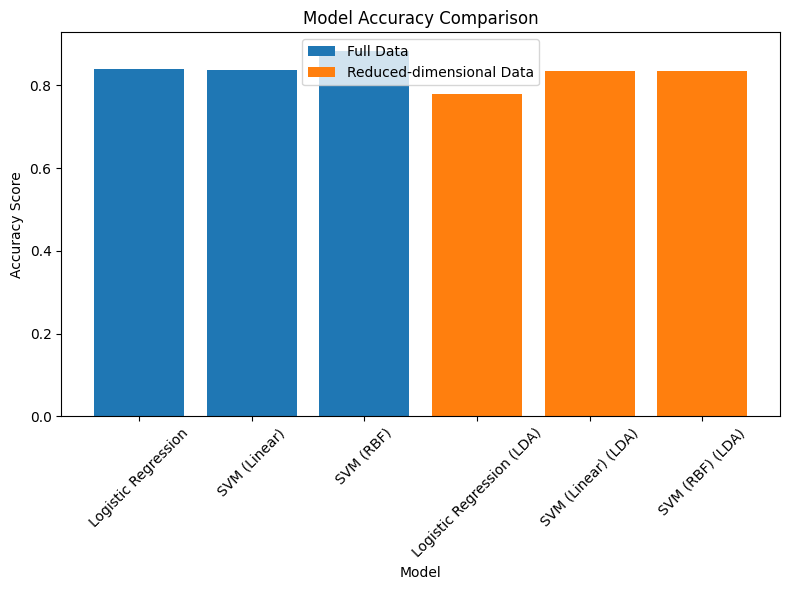

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))

# Bar plot for model accuracy
x = ['Logistic Regression', 'SVM (Linear)', 'SVM (RBF)']
y_full = [LR_acc_score, SVM_linear_acc_score, SVM_rbf_acc_score]
y_lda = [LR_lda_9_acc_score, SVM_linear_acc_score_lda_9, SVM_rbf_acc_score_lda_9]

ax.bar(x, y_full, label='Full Data')
ax.bar([x + ' (LDA)' for x in x], y_lda, label='Reduced-dimensional Data')

ax.set_title('Model Accuracy Comparison')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy Score')
ax.legend()
ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()
plt.show()